In [1]:
import rasterio
from rasterio.windows import from_bounds, transform
import numpy as np
import cv2
import os
from SatCam import SatCam, SatellitePose
import matplotlib.pyplot as plt
from ultralytics import YOLO
from rasterio.warp import calculate_default_transform, reproject
import pyproj

c:\Users\kmccl\anaconda3\envs\argus1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pose = [549496.7936069818, -6128343.990241624, 3287548.8567509046, -0.07876803246160267, 0.878472092968163, -0.4712561712468741, -0.04208625123151773, 0.46937312065726633, 0.8819963838144332, 0.9960041890069568, 0.08930652540881052, -0.0]
pose = SatellitePose(pose)
satcam = SatCam(pose, 66, 4608, 2592)
print(satcam.vfov)
print(np.deg2rad(satcam.vfov))

40.13366538082553
0.7004646017890694


In [3]:
current_regions = satcam.find_current_regions()
corner_lonlats = satcam.corner_lonlats
print(current_regions)
print(corner_lonlats)

['16R', '17R']
{'tl': (-89.06500134909436, 30.257888000513418), 'tr': (-80.68757210719025, 30.257888000513418), 'br': (-80.85294601399994, 26.17564331771982), 'bl': (-88.89962744228467, 26.175643317719818)}


2
4349 1319 694 6911
[[        694        1319]
 [       6911        1319]
 [       6911        4349]
 [        694        4349]]
[[        694        1319]
 [       6911        1319]
 [       6788        4349]
 [        816        4349]]
(3030, 6217, 3)


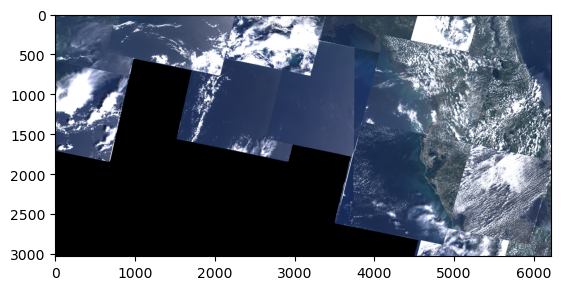

In [58]:
## Get Image
base_path = 'region_ims_4326'
regims = []
skip_regions = []
#crs = 'EPSG:32617'
#crs = 'EPSG:3857'
for region in current_regions:
    if region in skip_regions:
         continue
    if region is None:
        continue
    region_path = os.path.join(base_path, region)
    if os.path.exists(region_path):
        random_regim = np.random.choice(os.listdir(region_path))
        regim_path = os.path.join(region_path, random_regim)
        regims.append(regim_path)
print(len(regims))
if len(regims) > 1:

    data, affine = rasterio.merge.merge(regims)
    transformer = rasterio.transform.AffineTransformer(affine)
    tl_lon, tl_lat = corner_lonlats['tl']
    tr_lon, tr_lat = corner_lonlats['tr']
    bl_lon, bl_lat = corner_lonlats['bl']
    br_lon, br_lat = corner_lonlats['br']
    max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
    min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
    max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
    min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])

    tl_y_px, tl_x_px = transformer.rowcol(tl_lon, tl_lat)
    tr_y_px, tr_x_px = transformer.rowcol(tr_lon, tr_lat)
    bl_y_px, bl_x_px = transformer.rowcol(bl_lon, bl_lat)
    br_y_px, br_x_px = transformer.rowcol(br_lon, br_lat)

    max_lat_px, min_lon_px = transformer.rowcol(min_lon, min_lat)
    min_lat_px, max_lon_px = transformer.rowcol(max_lon, max_lat)

    print(max_lat_px, min_lat_px, min_lon_px, max_lon_px)
    
    points_dst = np.array([[min_lon_px, min_lat_px], [max_lon_px, min_lat_px], [max_lon_px, max_lat_px], [min_lon_px, max_lat_px]]).astype(np.float32)
    points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [br_x_px, br_y_px], [bl_x_px, bl_y_px]]).astype(np.float32)

    print(points_dst)
    print(points_src)
    M = cv2.getPerspectiveTransform(points_dst, points_src)
    data = np.moveaxis(data, 0, -1)
    warped = cv2.warpPerspective(data, M, (data.shape[1], data.shape[0]))
    
    #plt.imshow(warped)


    cropped = warped[min_lat_px:max_lat_px, min_lon_px:max_lon_px]
    plt.imshow(cropped)
    print(cropped.shape)
    #data = data_old[max_lat_px:min_lat_px, min_lon_px:max_lon_px]
    #plt.imshow(data_old)

    




    # print(data.shape)
    # tl_x, tl_y = transformer.xy(0, 0)
    # br_x, br_y = transformer.xy(data.shape[1], data.shape[2])
    # transform, width, height = calculate_default_transform('EPSG:4326', crs, data.shape[2], data.shape[1], tl_x, br_y, br_x, tl_y)
    # out = np.zeros((height, width, 3), dtype='uint8')
    # for i, band in enumerate(data, 1):
    #     dest = np.zeros((height, width), dtype=band.dtype)
    #     print(band.shape)
    #     reproject(
    #         band, dest,
    #         src_transform=affine,
    #         src_crs='EPSG:4326',
    #         dst_transform=transform,
    #         dst_crs=crs,
    #         resampling=0)

    #     if i >3:
    #         break
    #     out[:, :, i-1] = dest
    # print(out.shape)
    # p = pyproj.Proj(crs)
    # tl_lon, tl_lat = corner_lonlats['tl']
    # tr_lon, tr_lat = corner_lonlats['tr']
    # bl_lon, bl_lat = corner_lonlats['bl']
    # br_lon, br_lat = corner_lonlats['br']

    # tl_x, tl_y = p(tl_lon, tl_lat)
    # tr_x, tr_y = p(tr_lon, tr_lat)
    # bl_x, bl_y = p(bl_lon, bl_lat)
    # br_x, br_y = p(br_lon, br_lat)
    
    # max_x = max([tl_x, tr_x, bl_x, br_x])
    # max_y = max([tl_y, tr_y, bl_y, br_y])
    # min_x = min([tl_x, tr_x, bl_x, br_x])
    # min_y = min([tl_y, tr_y, bl_y, br_y])
    # data = out
    #data = np.moveaxis(data, 0, -1)
    # max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
    # min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
    # max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
    # min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
    #plt.imshow(data)
elif len(regims) == 1:
    with rasterio.open(regims[0]) as src:
        #transform, width, height = calculate_default_transform(src.crs, src.width, src.height, *src.bounds)
        tl_lon, tl_lat = corner_lonlats['tl']
        tr_lon, tr_lat = corner_lonlats['tr']
        bl_lon, bl_lat = corner_lonlats['bl']
        br_lon, br_lat = corner_lonlats['br']
        max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
        min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
        max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
        min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
        # data = src.read((1,2,3))
        # plt.imshow(np.moveaxis(data, 0, -1))
        
        print(src.bounds)
        print(min_lon, min_lat, max_lon, max_lat)

        window = from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
        window_transform = rasterio.windows.transform(window, src.transform)
        data = src.read((1,2,3), window=window, boundless = True)
        data = np.moveaxis(data, 0, -1)
        # plt.imshow(np.moveaxis(data, 0, -1))



#         transform, width, height = calculate_default_transform(src.crs, crs, src.width, src.height, *src.bounds)
#         # kwargs = src.meta.copy()
#         # kwargs.update({
#         #     'crs': crs,
#         #     'transform': transform,
#         #     'width': width,
#         #     'height': height
#         # })
#         data = src.read()
#         out = np.zeros((height, width, 3), dtype='uint8')
#         for i, band in enumerate(data, 1):
#             dest = np.zeros((height, width), dtype=band.dtype)
#             reproject(
#                 band, dest,
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=crs,
#                 resampling=0)
#             out[:, :, i-1] = dest

#         p = pyproj.Proj(crs)
#         tl_lon, tl_lat = corner_lonlats['tl']
#         tr_lon, tr_lat = corner_lonlats['tr']
#         bl_lon, bl_lat = corner_lonlats['bl']
#         br_lon, br_lat = corner_lonlats['br']

#         tl_x, tl_y = p(tl_lon, tl_lat)
#         tr_x, tr_y = p(tr_lon, tr_lat)
#         bl_x, bl_y = p(bl_lon, bl_lat)
#         br_x, br_y = p(br_lon, br_lat)

#         max_x = max([tl_x, tr_x, bl_x, br_x])
#         max_y = max([tl_y, tr_y, bl_y, br_y])
#         min_x = min([tl_x, tr_x, bl_x, br_x])
#         min_y = min([tl_y, tr_y, bl_y, br_y])

#         max_lon = max([tl_lon, tr_lon, bl_lon, br_lon])
#         min_lon = min([tl_lon, tr_lon, bl_lon, br_lon])
#         max_lat = max([tl_lat, tr_lat, bl_lat, br_lat])
#         min_lat = min([tl_lat, tr_lat, bl_lat, br_lat])
        
#         window = from_bounds(min_x, min_y, max_x, max_y, transform)
#         window_transform = rasterio.windows.transform(window, transform)
#         data = src.read((1,2,3), window=window, boundless = True)
#         data = np.moveaxis(data, 0, -1)
#         # print(data.shape)
#         plt.imshow(data)
#         plt.show()
# plt.imshow(data)
# plt.show()

0 0 6217 0 6094 3029 122 3029
[[          0           0]
 [       6217           0]
 [       6217        3030]
 [          0        3030]]
[[          0           0]
 [       6217           0]
 [       6094        3029]
 [        122        3029]]


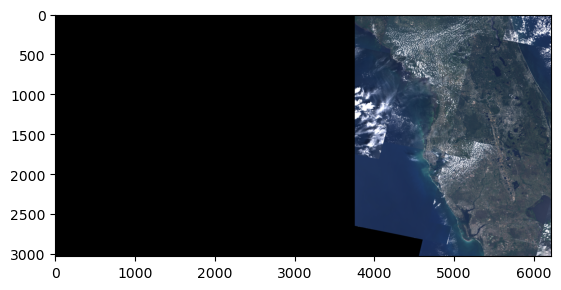

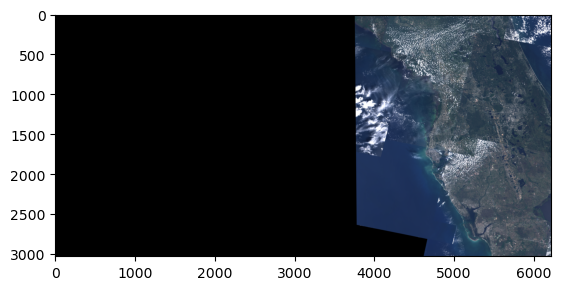

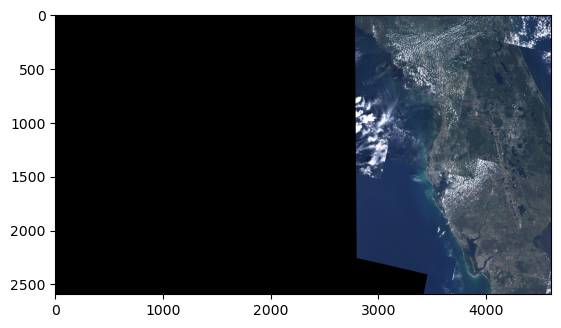

In [38]:
## 2nd case
transformer = rasterio.transform.AffineTransformer(window_transform)

p = pyproj.Proj('EPSG:3857')
tl_x, tl_y = p(tl_lon, tl_lat)
tr_x, tr_y = p(tr_lon, tr_lat)
bl_x, bl_y = p(bl_lon, bl_lat)
br_x, br_y = p(br_lon, br_lat)

tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
br_y_px, br_x_px = transformer.rowcol(br_x, br_y)

tl_y_px, tl_x_px = transformer.rowcol(tl_lon, tl_lat)
tr_y_px, tr_x_px = transformer.rowcol(tr_lon, tr_lat)
bl_y_px, bl_x_px = transformer.rowcol(bl_lon, bl_lat)
br_y_px, br_x_px = transformer.rowcol(br_lon, br_lat)

dst_width = 4608
dst_height = 2592

h, w = data.shape[:2]

points_dst = np.array([[0, 0], [w, 0], [w, h], [0, h]]).astype(np.float32)
print(tl_x_px, tl_y_px, tr_x_px, tr_y_px, br_x_px, br_y_px, bl_x_px, bl_y_px)
points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [br_x_px, br_y_px], [bl_x_px, bl_y_px]]).astype(np.float32)
print(points_dst)
print(points_src)
M = cv2.getPerspectiveTransform(points_src, points_dst)
plt.imshow(data)
plt.show()
warped = cv2.warpPerspective(data, M, (w, h))
resized = cv2.resize(warped, (dst_width, dst_height))
plt.imshow(warped)
plt.show()

plt.imshow(resized)
plt.show()

| 143.46, 0.00, 194760.75|
| 0.00,-143.46, 3548381.86|
| 0.00, 0.00, 1.00|
4553 -3386 1208 2337
-3290 1208 2337 1400 -3386 4385 2230 4553


ValueError: zero-size array to reduction operation minimum which has no identity

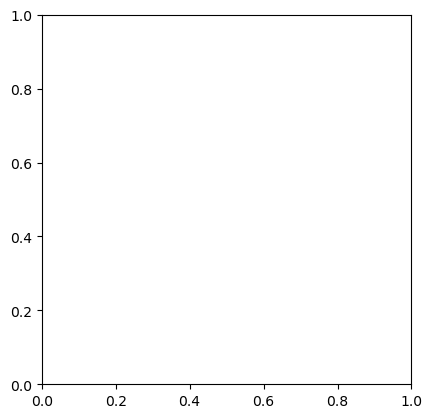

In [107]:
 ## first case
transformer = rasterio.transform.AffineTransformer(transform)
print(transform)
tl_y_px, tl_x_px = transformer.rowcol(tl_x, tl_y)
tr_y_px, tr_x_px = transformer.rowcol(tr_x, tr_y)
bl_y_px, bl_x_px = transformer.rowcol(bl_x, bl_y)
br_y_px, br_x_px = transformer.rowcol(br_x, br_y)
# minlat_y, minlon_x = transformer.rowcol(min_lon, min_lat)
# maxlat_y, maxlon_x = transformer.rowcol(max_lon, max_lat)
min_y_px, min_x_px = transformer.rowcol(min_x, min_y)
max_y_px, max_x_px = transformer.rowcol(max_x, max_y)
print(min_y_px, min_x_px, max_y_px, max_x_px)
print(tl_x_px, tl_y_px, tr_x_px, tr_y_px, bl_x_px, bl_y_px, br_x_px, br_y_px)

plt.imshow(data[max_y_px:min_y_px, min_x_px:max_x_px])
plt.show()

data_old = data
data = data[max_y_px:min_y_px, min_x_px:max_x_px]

dst_width = 4608
dst_height = 2592
h, w = data.shape[:2]
points_dst = np.array([[min_x_px, max_y_px], [max_x_px, max_y_px], [max_x_px, min_y_px], [min_x_px, min_y_px]]).astype(np.float32)
points_src = np.array([[tl_x_px, tl_y_px], [tr_x_px, tr_y_px], [br_x_px, br_y_px], [bl_x_px, bl_y_px]]).astype(np.float32)

M = cv2.getPerspectiveTransform(points_src, points_dst)
warped = cv2.warpPerspective(data, M, (w, h))
plt.imshow(warped)
#cropped = warped[maxlat_y:minlat_y, minlon_x:maxlon_x]
resized = cv2.resize(warped, (dst_width, dst_height))
plt.imshow(resized)
bgr = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)


In [9]:
import torch
for region in ['17R']:
    model_path = 'models/' + region + '.pt'
    model = YOLO(model_path)
    conf_threshold = float(np.load('best_confs/' + region + '_best_conf.npy'))
    best_classes = np.load('best_classes/' + region + '_best_classes.npy')
    results = model.predict(bgr, conf=conf_threshold, classes=best_classes, imgsz=(2592,4608))
    
    result = results[0]
    if len(result.boxes) > 0:
        classes = result.boxes.cls
        confs = result.boxes.conf
        xcs = result.boxes.xywh[:,0]
        ycs = result.boxes.xywh[:,1]
        im_dets = torch.stack([classes, xcs, ycs, confs], dim=1)


0: 2592x4608 1 46, 1 49, 1 51, 1 53, 1 54, 3 61s, 1 73, 1 85, 1 92, 1 101, 1 117, 1 138, 1 152, 1 162, 1 175, 1 186, 1 193, 1 194, 1 215, 1 218, 1 257, 1 266, 1 298, 1 304, 1 338, 1 339, 1 377, 1 383, 1 387, 1 389, 1 394, 1 414, 1 435, 1 447, 1 463, 64.5ms
Speed: 89.0ms preprocess, 64.5ms inference, 2.0ms postprocess per image at shape (1, 3, 2592, 4608)


In [19]:
import csv
print(im_dets)
print(best_classes)
best_classes = np.load('best_classes/' + region + '_best_classes.npy')
landmark_csv_path = 'landmark_csvs/' + region + '_top_salient.csv'
cnt = 0
with open(landmark_csv_path, 'r') as f:
    csv_reader = csv.DictReader(f)
    dictlist = list(csv_reader)
    for i, row in enumerate(csv_reader):
        if i in best_classes:
            cnt+=1
print(cnt)
print(dictlist)


tensor([[8.5000e+01, 3.5116e+03, 1.5628e+03, 9.8096e-01],
        [4.4700e+02, 3.5297e+03, 1.5040e+03, 9.5221e-01],
        [3.0400e+02, 3.9733e+03, 2.3261e+03, 9.3585e-01],
        [3.8900e+02, 4.0978e+03, 6.4328e+02, 9.2686e-01],
        [4.1400e+02, 3.5081e+03, 1.5127e+03, 9.2608e-01],
        [5.4000e+01, 4.2915e+03, 1.8070e+03, 9.1660e-01],
        [3.7700e+02, 3.5967e+03, 1.5852e+03, 9.1226e-01],
        [3.3800e+02, 3.4872e+03, 1.5197e+03, 9.1105e-01],
        [3.8300e+02, 4.4956e+03, 2.0537e+03, 9.1090e-01],
        [3.8700e+02, 3.8302e+03, 2.1584e+03, 8.9700e-01],
        [2.5700e+02, 4.5231e+03, 2.1780e+03, 8.7636e-01],
        [4.3500e+02, 4.5344e+03, 2.0777e+03, 8.7472e-01],
        [4.6300e+02, 4.5136e+03, 2.0716e+03, 8.6829e-01],
        [2.6600e+02, 3.8291e+03, 2.0983e+03, 8.6529e-01],
        [6.1000e+01, 3.4907e+03, 1.5099e+03, 8.6487e-01],
        [3.3900e+02, 4.5594e+03, 2.1475e+03, 8.5195e-01],
        [1.7500e+02, 3.5767e+03, 1.6122e+03, 8.5077e-01],
        [3.940